# Silverbox

Silverbox refers to one of the nonlinear system identification benchmarks on http://nonlinearbenchmark.org/#Silverbox. 
It is a simulation of a [Duffing oscillator](https://en.wikipedia.org/wiki/Duffing_equation), ocurring for instance in nonlinear spring pendulums.

State-space model description of the system:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} + c \frac{d x(t)}{dt} + a x(t) + b x^3(t) =&\ u(t) + w(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
m     =&\ \text{mass} \\
c     =&\ \text{damping} \\
a     =&\ \text{linear stiffness} \\
b     =&\ \text{nonlinear stiffness} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
v(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

The process noise is a Wiener process, where the increment is Gaussian distributed $w(t) \sim \mathcal{N}(0, \tau^{-1}dt)$. The parameter $\tau$ represents the precision of the process. The measurement noise is also a Wiener process, $v(t) \sim \mathcal{N}(0, \xi^{-1}dt)$.

## Solution steps

### 1. Discretize

I'm using a central difference for the second derivative and a forward difference for the first derivative. Let $w_t$ be a sample from $\mathcal{N}(0, \tau^{-1})$. The state transition can now be written as the following discrete-time system:

$$\begin{align}
m (x_{t+1} - 2x_{t} + x_{t-1}) + c (x_{t+1} - x_{t}) + a x_t + b x_t^3 =&\ u_t + w_t
\end{align}$$
Re-writing this as a function of $x_{t+1}$ yields:
$$\begin{align}
% (m + c) x_{t+1}&\ + (-2m - c + a) x_{t} + bx_t^3 + m x_{t-1} = u_t + w_t \\
x_{t+1}&\ = \frac{2m + c - a}{m + c} x_{t} + \frac{-b}{m + c}x_t^3 + \frac{-m}{m + c} x_{t-1} + \frac{1}{m + c} u_t + \frac{1}{m + c} w_t \, .
\end{align}$$

### 2. Substitute variables and reduce order

I can cast the above system into matrix form:

$$ \underbrace{\begin{bmatrix} x_{t+1} \\ x_{t} \end{bmatrix}}_{z_t} = \underbrace{\begin{bmatrix} 0 & 0 \\ 1 & 0 \end{bmatrix}}_{S} \underbrace{\begin{bmatrix} x_{t} \\ x_{t-1} \end{bmatrix}}_{z_{t-1}} + \underbrace{\begin{bmatrix} 1 \\ 0 \end{bmatrix}}_{e} g(z_{t-1}, \theta) + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \eta u_t + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \tilde{w}_t \, ,$$

where

$$\begin{align}
\theta_1 =&\ \frac{2m+c-a}{m+c} \\
\theta_2 =&\ \frac{-b}{m+c} \\
\theta_3 =&\ \frac{-m}{m+c} \\
\eta =&\ \frac{1}{m+c} \\
\gamma^{-1} =& \tau^{-1} \frac{1}{(m+c)^2} \, ,
\end{align}$$

and $g(z_{t-1}, \theta) = \theta_1 x_t + \theta_2 x_t^3 + \theta_3 x_{t-1}$ and $\tilde{w}_t \sim \mathcal{N}(0, \gamma^{-1})$. In total, I have five unknowns $m,c,a,b,\tau$ and five equations. I can invert the mapping between $\phi = (m, c, a, b, \tau)$ and $\psi = (\theta_1, \theta_2, \theta_3, \eta, \gamma)$ to recover MAP estimates for the physical parameters. Variable substitution allows for more freedom in choosing priors.

The system is now a nonlinear autoregressive process:

$$z_t = f(z_{t-1}, \theta, \eta, u_t) + \tilde{w}_t$$

where $f(z_{t-1}, \theta, \eta, u_t) = Sz_{t-1} + e g(z_{t-1}, \theta) + e \eta u_t$. Note that we need a two-dimensional state prior now (reminiscent of adding an initial condition on the velocity).

### 3. Convert to Gaussian probability

Integrating out $\tilde{w}_t$ and $v_t$ produces a Gaussian state transition node:

$$\begin{align}
z_t \sim&\ \mathcal{N}(f(z_{t-1}, \theta, \eta, u_t), V) \\
y_t \sim&\ \mathcal{N}(e^{\top} z_t, \xi^{-1}) \, ,
\end{align}$$

where $V = \begin{bmatrix} \gamma^{-1} & 0 \\ 0 & \epsilon \end{bmatrix}$ and $W = V^{-1} = \begin{bmatrix} \gamma & 0 \\ 0 & \epsilon^{-1} \end{bmatrix}$.

### 6. Choose priors

We know that mass $m$ and process precision $\gamma$ are strictly positive parameters and that the damping and stiffness coefficients can be both positive and negative. By examing the nonlinear transform $\psi = G(\phi)$, we realize that $\theta_1$, $\theta_2$, $\theta_3$ and $\eta$ can be both positive and negative, but $\gamma$ can only be positive. As such, we choose the following priors:

$$\begin{align}
\theta \sim&\ \text{Normal}(m^{0}_{\theta}, V^{0}_{\theta}) \\
\eta \sim&\ \text{Normal}(m^{0}_{\eta}, v^{0}_{\eta}) \\ 
\gamma \sim&\ \text{Gamma}(a^{0}_\gamma, b^{0}_\gamma) \, .
\end{align}$$

### 7. Recover physical variables from substituted ones

Since we have five equations and five unknowns, we can perfectly recover point estimates of the physical variables from substituted ones. However, we don't want point estimates, we want posteriors. 

If we approximate $\gamma$ with a log-Normal distribution and then map it to a Gaussian distribution (i.e. model $\tilde{\gamma} = \log(\gamma)$), we end up with a Gaussian distributed random vector $\psi = [\theta_1, \theta_2, \theta_3, \eta, \tilde{\gamma}]$. We can perform a Gaussian approximation of the inverse mapping $G^{-1}(\psi)$ using a first-order Taylor expansion:

$$\begin{align}
m_{\phi} \triangleq \mathbb{E}[G^{-1}(\psi)] =&\ G^{-1}(m_{\psi}) \\
V_{\phi} \triangleq \mathbb{V}[G^{-1}(\psi)] =&\ J_{\psi}(m_{\psi}) G^{-1}(m_{\psi}) J_{\psi}(m_{\psi})^{\top} \, ,
\end{align}$$

The inverse mapping has the form:

$$\begin{align} 
m =&\ \frac{-\theta_3}{\eta} \\
c =&\ \frac{1+\theta_3}{\eta} \\
a =&\ \frac{(1-\theta_1 - \theta_3)}{\eta} \\
b =&\ \frac{-\theta_2}{\eta} \\
\tau =&\ \tilde{\gamma} \eta^2 \, .
\end{align}$$

The Jacobian can be obtained automatically using Julia packages such as ForwardDiff.jl or Zygote.jl.

### Data

Let's first have a look at the data.

In [1]:
using Revise
using CSV
using DataFrames

In [2]:
using Plots
viz = true;

In [81]:
# Read data from CSV file
df = CSV.read("../data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Shorthand
input = df[:,1]
output = df[:,2]

# Time horizon
T = size(df, 1)

131072

In [82]:
# Select training set
trn = collect(50001:131072)
input_trn = input[trn]
output_trn = output[trn]
T_trn = length(trn)

# Select validation set
val = 1:40000
input_val = input[val]
output_val = output[val]
T_val = length(val)

40000

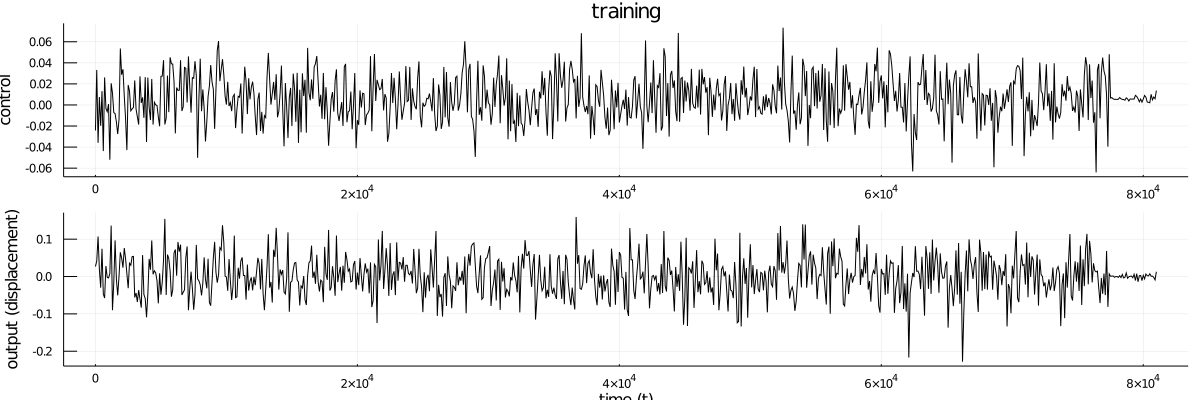

In [89]:
# Plot every n-th time-point to avoid figure size exploding
n = 100

if viz
    p1a = Plots.plot(1:n:T_trn, input_trn[1:n:end], color="black", label="", markersize=2, xlabel="", ylabel="control", size=(1200,400), title="training")    
    p1b = Plots.plot(1:n:T_trn, output_trn[1:n:end], color="black", label="", markersize=2, xlabel="time (t)", ylabel="output (displacement)", size=(1200,400))    
    plot(p1a, p1b, layout=(2,1))
#     Plots.savefig(p1a, "viz/training_set.png")
end

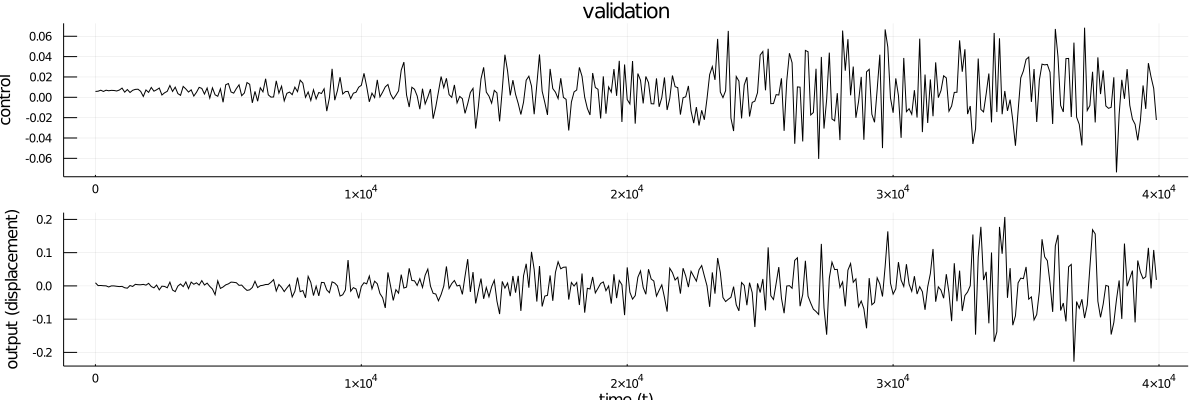

In [90]:
if viz
    p1a = Plots.plot(1:n:T_val, input_val[1:n:end], color="black", label="", markersize=2, xlabel="", ylabel="control", size=(1200,400), title="validation")    
    p1b = Plots.plot(1:n:T_val, output_val[1:n:end], color="black", label="", markersize=2, xlabel="time (t)", ylabel="output (displacement)", size=(1200,400))    
    plot(p1a, p1b, layout=(2,1))
#     Plots.savefig(p1a, "viz/validation_set.png")
end

## Estimating parameters via Bayesian filtering

Implementation with ForneyLab and AR node. The AR node is locally modified from the package LAR (LAR is in dev mode). It now contains an AutoregressiveControlNL node, where I can add a nonlinearity g as an argument.

The major change from a linear AR to a nonlinear AR node is in working out the expectations for $g(x,\theta)$ as opposed to $\theta^{\top}x$. There are a number of ways of doing this. I have chosen a first-order Taylor approximation:

$$ g(x,\theta) = g(m_x, m_{\theta}) + J_{x}(m_x, m_{\theta})^{\top}(x - m_x) + J_{\theta}(m_x, m_{\theta})^{\top}(\theta - m_{\theta}) \, ,$$

where $J_x$ denotes the partial derivative of $g$ with respect to $x$ and $J_{\theta}$ w.r.t. $\theta$. Note that our current $g$ is linear in $\theta$ and you could argue that you don't need to approximate it. However, the first-order Taylor is exact in that case.

In [91]:
using LinearAlgebra
using ForneyLab
using ForneyLab: unsafeMean, unsafeCov, unsafeVar, unsafePrecision
using LAR
using LAR.Node, LAR.Data
using ProgressMeter

In [92]:
using Zygote

function Jacobian(F, x)
    y = F(x)
    n = length(y)
    m = length(x)
    T = eltype(y)
    j = Array{T, 2}(undef, n, m)
    for i in 1:n
        j[i, :] .= gradient(x -> F(x)[i], x)[1]
    end
    return j
end;

In [106]:
# Start graph
graph1 = FactorGraph()

# Static parameters
@RV Œ∏ ~ GaussianMeanPrecision(placeholder(:m_Œ∏, dims=(3,)), placeholder(:w_Œ∏, dims=(3,3)))
@RV Œ∑ ~ GaussianMeanPrecision(placeholder(:m_Œ∑), placeholder(:w_Œ∑))
@RV Œ≥ ~ Gamma(placeholder(:a_Œ≥), placeholder(:b_Œ≥))
@RV Œæ ~ Gamma(placeholder(:a_Œæ), placeholder(:b_Œæ))

# Nonlinearity
g(x,Œ∏) = Œ∏[1]*x[1] + Œ∏[2]*x[1]^3 + Œ∏[3]*x[2]

# State prior
@RV z_t ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_t)

# Autoregressive node
@RV x_t ~ AutoregressiveControlNL(Œ∏, z_t, Œ∑, placeholder(:u_t), Œ≥, g=g, id=:x_t)

# Specify likelihood
@RV y_t ~ GaussianMeanPrecision(dot([1. , 0.], x_t), Œæ, id=:y_t)

# Placeholder for observation
placeholder(y_t, :y_t)

# Draw time-slice subgraph
ForneyLab.draw(graph)

# Infer an algorithm
q1 = PosteriorFactorization(z_t, x_t, Œ∏, Œ∑, Œ≥, Œæ, ids=[:z, :x, :Œ∏, :Œ∑, :Œ≥, :Œæ])
algo1 = variationalAlgorithm(q1, free_energy=false)
source_code1 = algorithmSourceCode(algo1, free_energy=false)
eval(Meta.parse(source_code1));
# println(source_code)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 8965970257281034088 -->
 
 8965970257281034088 
 
 placeholder_w_z 
 
<!-- 13329601251321433225 -->
 
 13329601251321433225 
 
 ùí© 
 z_t 
 
<!-- 13329601251321433225--8965970257281034088 -->
 
 13329601251321433225--8965970257281034088 
 
 w_z 
 1 out 
 3 w 
 
<!-- 4300126490080177230 -->
 
 4300126490080177230 
 
 placeholder_m_z 
 
<!-- 13329601251321433225--4300126490080177230 -->
 
 13329601251321433225--4300126490080177230 
 
 m_z 
 1 out 
 2 m 
 
<!-- 17564544349443467411 -->
 
 17564544349443467411 
 
 ARCNL 
 x_t 
 
<!-- 17564544349443467411--13329601251321433225 -->
 
 17564544349443467411--13329601251321433225 
 
 z_t 
 1 out 
 2 x 
 
<!-- 11484857054437432384 -->
 
 11484857054437432384 
 
 placeholder_Œ≥ 
 
<!-- 17564544349443467411--11484857054437432384 -->
 
 17564544349443467411--11484857054437432384 
 
 Œ≥ 
 1 out 
 6 Œ≥ 
 
<!-- 18097704596988040418 -->
 
 18097704596988040418 
 
 placeholder_u_t 
 
<!-- 17564544349443467411--18097704596988040418 -->
 
 17564544349443467411--18097704596988040418 
 
 u_t 
 1 out 
 5 u 
 
<!-- 15371736771897534316 -->
 
 15371736771897534316 
 
 placeholder_Œ∑ 
 
<!-- 17564544349443467411--15371736771897534316 -->
 
 17564544349443467411--15371736771897534316 
 
 Œ∑ 
 1 out 
 4 Œ∑ 
 
<!-- 13021854747484369096 -->
 
 13021854747484369096 
 
 placeholder_Œ∏ 
 
<!-- 17564544349443467411--13021854747484369096 -->
 
 17564544349443467411--13021854747484369096 
 
 Œ∏ 
 1 out 
 3 Œ∏ 
 
<!-- 145374813426750296752 -->
 
 145374813426750296752 
 
<!-- 145374813426750296752--17564544349443467411 -->
 
 145374813426750296752--17564544349443467411 
 
 x_t 
 1 y

### Infer parameters

In [107]:
# Inference parameters
num_iterations = 10

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_x = (zeros(2,T_trn+1), repeat(.1 .*float(eye(2)), outer=(1,1,T_trn+1)))
params_Œ∏ = (ones(3,T_trn+1), repeat(.1 .*float(eye(3)), outer=(1,1,T_trn+1)))
params_Œ∑ = (ones(1,T_trn+1), .1*ones(1,T_trn+1))
params_Œ≥ = (1. *ones(1,T_trn+1), .1 *ones(1,T_trn+1))
params_Œæ = (1e6*ones(1,T_trn+1), 1e2*ones(1,T_trn+1))

# Initialize physical coefficient estimate arrays
params_œï = (zeros(5,T_trn), zeros(5,5,T_trn))
params_œà = (zeros(5,T_trn), zeros(5,5,T_trn))

# Transformations between physical and substituted variables: œà = G(œï) => œï = G_inv(œà)
G(œï) = [(2*œï[1] + œï[2] - œï[3])/(œï[1]+œï[2]), -œï[4]/(œï[1]+œï[2]), -œï[1]/(œï[1]+œï[2]), 1/(œï[1]+œï[2]), œï[5]*(œï[1]+œï[2])^2]
G_inv(œà) = [-œà[3]/œà[4], (1+œà[3])/œà[4], (1 - œà[1] - œà[3])/œà[4], -œà[2]/œà[4], œà[5]*œà[4]^2]

# Start progress bar
p = Progress(T_trn, 1, "At time ")

# Perform inference at each time-step
for t = 1:T_trn

    # Update progress bar
    update!(p, t)
    
    "Filtering"

    # Initialize marginals
    marginals[:x_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:Œ∏] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_Œ∏[1][:,t], w=params_Œ∏[2][:,:,t])
    marginals[:Œ∑] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_Œ∑[1][1,t], w=params_Œ∑[2][1,t])
    marginals[:Œ≥] = ProbabilityDistribution(Univariate, Gamma, a=params_Œ≥[1][1,t], b=params_Œ≥[2][1,t])
    marginals[:Œæ] = ProbabilityDistribution(Univariate, Gamma, a=params_Œæ[1][1,t], b=params_Œæ[2][1,t])
    
    data = Dict(:y_t => output_trn[t],
                :u_t => input_trn[t],
                :m_z => params_x[1][:,t],
                :w_z => params_x[2][:,:,t],
                :m_Œ∏ => params_Œ∏[1][:,t],
                :w_Œ∏ => params_Œ∏[2][:,:,t],
                :m_Œ∑ => params_Œ∑[1][1,t],
                :w_Œ∑ => params_Œ∑[2][1,t],
                :a_Œ≥ => params_Œ≥[1][1,t],
                :b_Œ≥ => params_Œ≥[2][1,t],
                :a_Œæ => params_Œæ[1][1,t],
                :b_Œæ => params_Œæ[2][1,t])

    # Iterate variational parameter updates
    for i = 1:num_iterations

        stepx!(data, marginals)
        stepŒ∏!(data, marginals)
        stepŒ∑!(data, marginals)
        stepŒ≥!(data, marginals)
        stepz!(data, marginals)
        stepŒæ!(data, marginals)
    end

    # Store current parameterizations of marginals
    params_x[1][:,t+1] = unsafeMean(marginals[:x_t])
    params_x[2][:,:,t+1] = marginals[:x_t].params[:w]
    params_Œ∏[1][:,t+1] = unsafeMean(marginals[:Œ∏])
    params_Œ∏[2][:,:,t+1] = marginals[:Œ∏].params[:w]
    params_Œ∑[1][1,t+1] = unsafeMean(marginals[:Œ∑])
    params_Œ∑[2][1,t+1] = marginals[:Œ∑].params[:w]
    params_Œ≥[1][1,t+1] = marginals[:Œ≥].params[:a]
    params_Œ≥[2][1,t+1] = marginals[:Œ≥].params[:b]
    params_Œæ[1][1,t+1] = marginals[:Œæ].params[:a]
    params_Œæ[2][1,t+1] = marginals[:Œæ].params[:b]
    
    "Map substituted to physical variables via first-order Taylor"
    
    # Approximate gamma with log-normal via moment-matching
    EŒ≥ = unsafeMean(marginals[:Œ≥])
    VŒ≥ = unsafeVar(marginals[:Œ≥])
    m_Œ≥ = log(EŒ≥^2/sqrt(VŒ≥ + EŒ≥^2))
    v_Œ≥ = log(VŒ≥/EŒ≥^2 + 1)

    # Construct vector of parameter estimates œà
    m_œà = [unsafeMean(marginals[:Œ∏])[1], unsafeMean(marginals[:Œ∏])[2], unsafeMean(marginals[:Œ∏])[3], unsafeMean(marginals[:Œ∑])[1], m_Œ≥]
    V_œà = [unsafeCov(marginals[:Œ∏]) zeros(3,2); zeros(2,3) [unsafeCov(marginals[:Œ∑])[1,1] 0;0 v_Œ≥]]
    
    # Store psi
    params_œà[1][:,t] = m_œà
    params_œà[2][:,:,t] = V_œà
    
    # Compute Jacobian of transformation 
    J_œà = Jacobian(G_inv, m_œà)
    
    # Compute moments of transformed Gaussian using first-order Taylor approx
    m_œï = G_inv(m_œà)
    V_œï = J_œà*V_œà*J_œà'
    
    # Store phi
    params_œï[1][:,t] = m_œï
    params_œï[2][:,:,t] = V_œï

end

At time 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:01:33


### Forecast on validation data

In [113]:
# Start graph
graph2 = FactorGraph()

# Nonlinearity
g(x,Œ∏) = Œ∏[1]*x[1] + Œ∏[2]*x[1]^3 + Œ∏[3]*x[2]

# State prior
@RV z_t ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_t)

# Autoregressive node
@RV x_t ~ AutoregressiveControlNL(placeholder(:Œ∏, dims=(3,)), z_t, placeholder(:Œ∑), placeholder(:u_t), placeholder(:Œ≥), g=g, id=:x_t)

# Draw time-slice subgraph
ForneyLab.draw(graph)

# Infer an algorithm
q2 = PosteriorFactorization(z_t, x_t, ids=[:z, :x])
algo2 = variationalAlgorithm(q2, free_energy=false)
source_code2 = algorithmSourceCode(algo2, free_energy=false)
eval(Meta.parse(source_code2));
# println(source_code)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 8965970257281034088 -->
 
 8965970257281034088 
 
 placeholder_w_z 
 
<!-- 13329601251321433225 -->
 
 13329601251321433225 
 
 ùí© 
 z_t 
 
<!-- 13329601251321433225--8965970257281034088 -->
 
 13329601251321433225--8965970257281034088 
 
 w_z 
 1 out 
 3 w 
 
<!-- 4300126490080177230 -->
 
 4300126490080177230 
 
 placeholder_m_z 
 
<!-- 13329601251321433225--4300126490080177230 -->
 
 13329601251321433225--4300126490080177230 
 
 m_z 
 1 out 
 2 m 
 
<!-- 17564544349443467411 -->
 
 17564544349443467411 
 
 ARCNL 
 x_t 
 
<!-- 17564544349443467411--13329601251321433225 -->
 
 17564544349443467411--13329601251321433225 
 
 z_t 
 1 out 
 2 x 
 
<!-- 11484857054437432384 -->
 
 11484857054437432384 
 
 placeholder_Œ≥ 
 
<!-- 17564544349443467411--11484857054437432384 -->
 
 17564544349443467411--11484857054437432384 
 
 Œ≥ 
 1 out 
 6 Œ≥ 
 
<!-- 18097704596988040418 -->
 
 18097704596988040418 
 
 placeholder_u_t 
 
<!-- 17564544349443467411--18097704596988040418 -->
 
 17564544349443467411--18097704596988040418 
 
 u_t 
 1 out 
 5 u 
 
<!-- 15371736771897534316 -->
 
 15371736771897534316 
 
 placeholder_Œ∑ 
 
<!-- 17564544349443467411--15371736771897534316 -->
 
 17564544349443467411--15371736771897534316 
 
 Œ∑ 
 1 out 
 4 Œ∑ 
 
<!-- 13021854747484369096 -->
 
 13021854747484369096 
 
 placeholder_Œ∏ 
 
<!-- 17564544349443467411--13021854747484369096 -->
 
 17564544349443467411--13021854747484369096 
 
 Œ∏ 
 1 out 
 3 Œ∏ 
 
<!-- 145374813426750296752 -->
 
 145374813426750296752 
 
<!-- 145374813426750296752--17564544349443467411 -->
 
 145374813426750296752--17564544349443467411 
 
 x_t 
 1 y

In [118]:
# Inference parameters
num_iterations = 10

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_x = (zeros(2,T_val+1), repeat(.1 .*float(eye(2)), outer=(1,1,T_val+1)))

# Start progress bar
p = Progress(T_val, 1, "At time ")

# Perform inference at each time-step
for t = 1:T_val

    # Update progress bar
    update!(p, t)
    
    "Filtering"

    # Initialize marginals
    marginals[:x_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    
    data = Dict(:u_t => input_val[t],
                :m_z => params_x[1][:,t],
                :w_z => params_x[2][:,:,t],
                :Œ∏ => params_Œ∏[1][:,end],
                :Œ∑ => params_Œ∑[1][end],
                :Œ≥ => params_Œ≥[1][end]/params_Œ≥[2][end])

    # Iterate variational parameter updates
    for i = 1:num_iterations
        stepx!(data, marginals)
        stepz!(data, marginals)
    end

    # Store current parameterizations of marginals
    params_x[1][:,t+1] = unsafeMean(marginals[:x_t])
    params_x[2][:,:,t+1] = marginals[:x_t].params[:w]

end

At time 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:00:13


### Visualize results

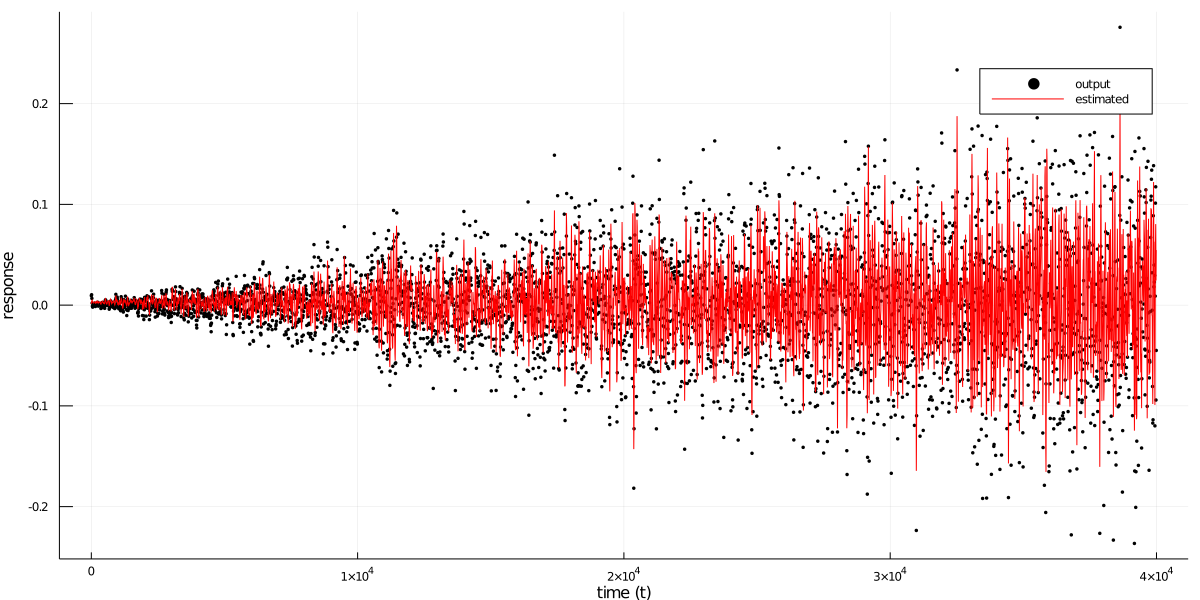

In [119]:
# Extract mean of state marginals
estimated_states = params_x[1][1,2:end]

# Plot every n-th time-point to avoid figure size exploding
n = 10

p1 = Plots.scatter(1:n:T_val, output_val[1:n:T_val], color="black", label="output", markersize=2, size=(1200,600), xlabel="time (t)", ylabel="response")
Plots.plot!(1:n:T_val, estimated_states[1:n:T_val], color="red", linewidth=1, label="estimated")
#     Plots.savefig(p1, "viz/nonlin_estimated_states01.png")

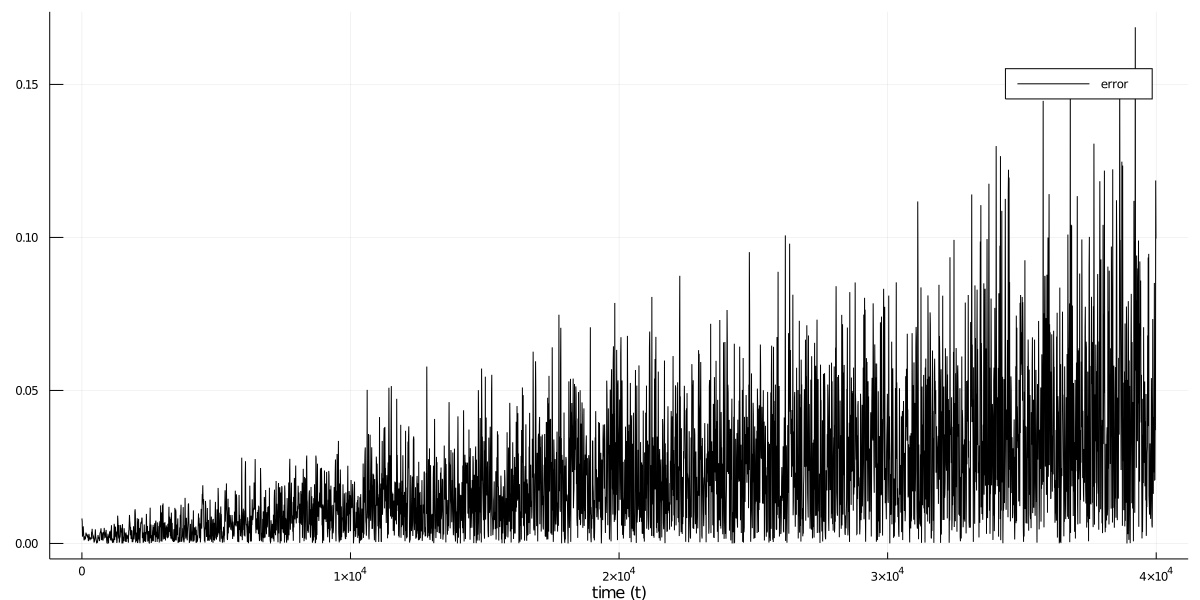

In [120]:
# Error plot
error = abs.(estimated_states[1:n:T_val] .- output_val[1:n:T_val])

Plots.plot(1:n:T_val, error, color="black", label="error", markersize=2, size=(1200,600), xlabel="time (t)", ylabel="")

In [121]:
println("RMSE = "*string(sqrt(mean(error))))

RMSE = 0.1484695173848057


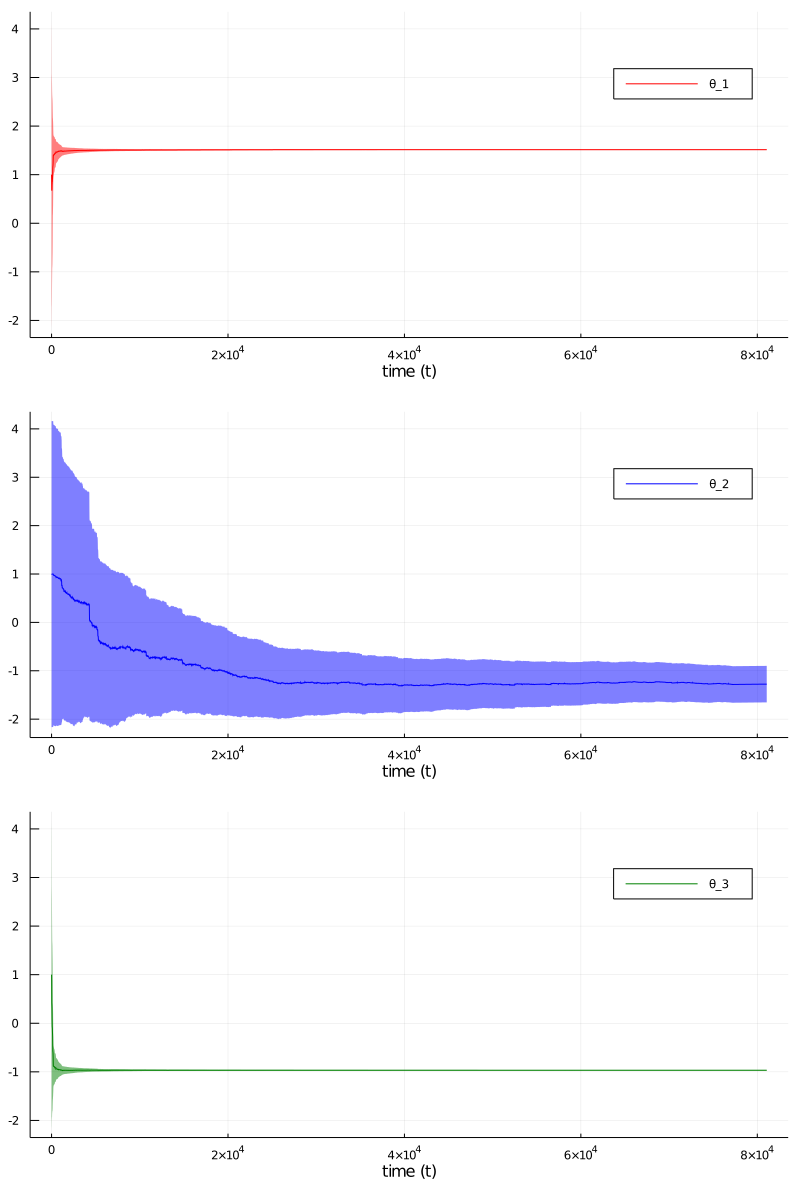

In [109]:
# Extract mean of coefficient marginals
estimated_Œ∏1_mean = params_Œ∏[1][1,2:end]
estimated_Œ∏2_mean = params_Œ∏[1][2,2:end]
estimated_Œ∏3_mean = params_Œ∏[1][3,2:end]
estimated_Œ∏1_std = sqrt.(inv.(params_Œ∏[2][1,1,2:end]))
estimated_Œ∏2_std = sqrt.(inv.(params_Œ∏[2][2,2,2:end]))
estimated_Œ∏3_std = sqrt.(inv.(params_Œ∏[2][3,3,2:end]))

# Plot both coefficients next to each other
p2a = Plots.plot(1:n:T_trn, estimated_Œ∏1_mean[1:n:T_trn], ribbon=[estimated_Œ∏1_std[1:n:T_trn], estimated_Œ∏1_std[1:n:T_trn]], color="red", label="Œ∏_1", xlabel="time (t)")
p2b = Plots.plot(1:n:T_trn, estimated_Œ∏2_mean[1:n:T_trn], ribbon=[estimated_Œ∏2_std[1:n:T_trn], estimated_Œ∏2_std[1:n:T_trn]], color="blue", label="Œ∏_2", xlabel="time (t)")
p2c = Plots.plot(1:n:T_trn, estimated_Œ∏3_mean[1:n:T_trn], ribbon=[estimated_Œ∏3_std[1:n:T_trn], estimated_Œ∏3_std[1:n:T_trn]], color="green", label="Œ∏_3", xlabel="time (t)")
p2 = plot(p2a, p2b, p2c, layout=(3,1), size=(800,1200))
#     Plots.savefig(p2, "viz/nonlin_estimated_Œ∏.png")

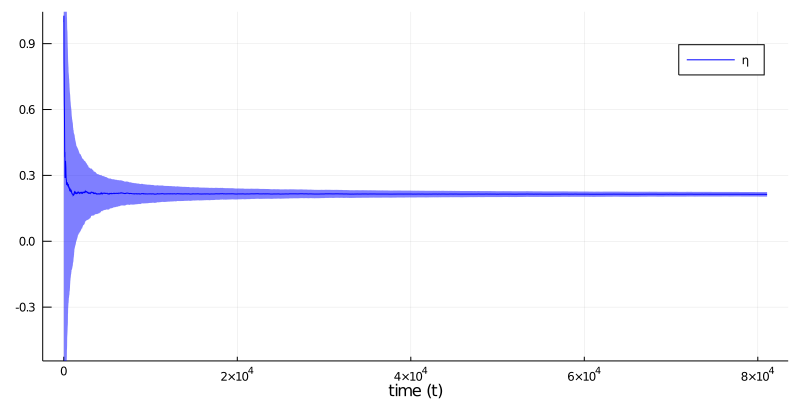

In [110]:
# Extract mean of control coefficient marginals
estimated_Œ∑_mean = params_Œ∑[1][1,2:end]
estimated_Œ∑_std = sqrt.(inv.(params_Œ∑[2][1,2:end]))

# Plot both coefficients next to each other
p3 = Plots.plot(1:n:T_trn, estimated_Œ∑_mean[1:n:T_trn], ribbon=[estimated_Œ∑_std[1:n:T_trn], estimated_Œ∑_std[1:n:T_trn]], color="blue", label="Œ∑", xlabel="time (t)", ylim=[-.5, 1.], size=(800,400))
#     Plots.savefig(p3, "viz/nonlin_estimated_Œ∑.png")

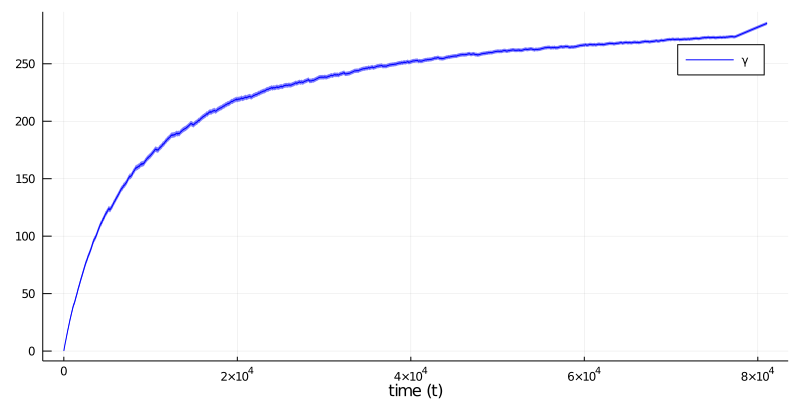

In [111]:
# Extract mean of process precision marginals
estimated_Œ≥_mean = params_Œ≥[1][1,2:end] ./ params_Œ≥[2][1,2:end]
estimated_Œ≥_std = sqrt.(params_Œ≥[1][1,2:end] ./ params_Œ≥[2][1,2:end].^2)

    # Plot both coefficients next to each other
    p4 = Plots.plot(1:n:T_trn, estimated_Œ≥_mean[1:n:T_trn], ribbon=[estimated_Œ≥_std[1:n:T_trn], estimated_Œ≥_std[1:n:T_trn]], color="blue", label="Œ≥", xlabel="time (t)", size=(800,400))
#     Plots.savefig(p4, "viz/nonlin_estimated_Œ≥.png")

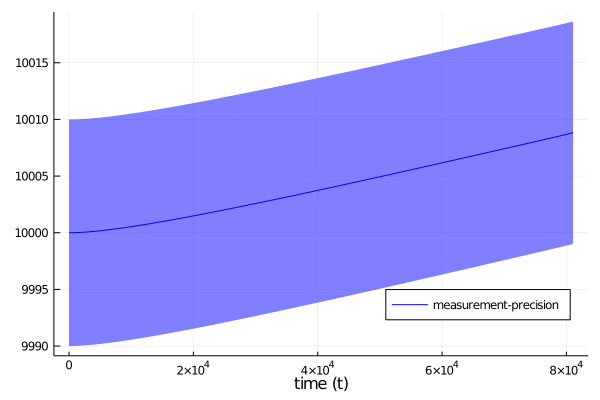

In [112]:
# Extract mean of measurement precision marginals
estimated_Œæ_mean = params_Œæ[1][1,2:end] ./ params_Œæ[2][1,2:end]
estimated_Œæ_std = sqrt.(params_Œæ[1][1,2:end] ./ params_Œæ[2][1,2:end].^2)

if viz
    # Plot both coefficients next to each other
    p8 = Plots.plot(1:n:T_trn, estimated_Œæ_mean[1:n:T_trn], ribbon=[estimated_Œæ_std[1:n:T_trn], estimated_Œæ_std[1:n:T_trn]], color="blue", label="measurement-precision", xlabel="time (t)", size=(600,400), legend=:bottomright)
#     Plots.savefig(p8, "viz/nonlin_estimated_measurement-precision_600x400.png")
end